<p style="text-align: center; font-size:50px;">Simple GANs using PyTorch</p>

#### With Generative AI being hyped up these days, I think it's worth to take a look at what a GAN is and provide a simple example about it. 
#### I have made another notebook talking about a more complicated version of this, so if you would like to begin with a simpler version, do follow along this notebook!

##### This notebook was inspired by this [tutorial](https://jovian.com/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-6-image-generation-using-gans?notebook=aakashns/06-mnist-gan) and you can find more of these tutorials there. 

#### You might be wondering what a GAN is. 
#### Generative modeling is an **unsupervised** learning task in which machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.
#### Basically, it will learn patterns and probability distributions from the training data, and closely emulate them.

#### The general overview is that there are 2 neural networks: a Generator and a Discriminator.
#### The generator generates a 'fake' sample given a random vector/atrix, and the discriminator attempts to detect whether a given sample is 'real' or 'fake'.
#### Training happens in tandem, which means we take turns training the generator and discriminator. 
#### This way, both the generator and discriminator both gets better at performing their respective jobs. 
#### However, GANs are notorious for being difficult to train, as they can be extremely sensitive to hyperparameters, activation functions and regularization.
#### In this tutorial, we will built a GAN to generate images of handwritten digits similar to those from the MNIST database.

<p style="text-align: center; font-size:30px;">Load the Data</p>

#### Let us first load the data using the MNIST helper class from torchvision.dataset.


In [15]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='../data/', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

#### Let's take a look at a single data.

Label: 5


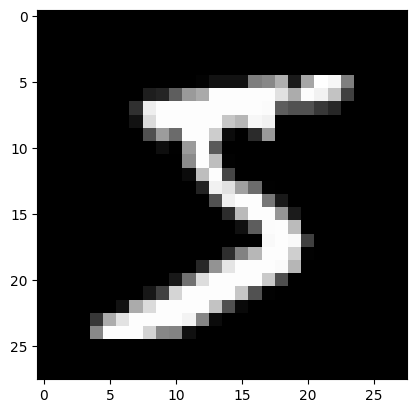

In [16]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

import matplotlib.pyplot as plt
%matplotlib inline

img, label = mnist[0]

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

#### Ok, seems like our data was downloaded with any errors.
#### Let's now create a dataloader to load images in batches.
#### This can be done with the DataLoader from torch.utils.data

first batch
torch.Size([100, 1, 28, 28]) -> [batch_size, color channel, dimension, dimension]
tensor([0, 1, 8, 0, 5, 4, 8, 8, 1, 5, 5, 5, 9, 7, 4, 4, 2, 8, 0, 6, 4, 5, 7, 1,
        4, 3, 3, 9, 6, 5, 8, 1, 8, 2, 2, 8, 3, 0, 5, 3, 9, 8, 7, 1, 7, 4, 1, 8,
        9, 4, 5, 3, 6, 2, 4, 2, 5, 4, 8, 5, 4, 8, 1, 3, 3, 6, 1, 6, 8, 8, 5, 8,
        9, 7, 2, 1, 5, 6, 2, 5, 1, 2, 6, 5, 9, 3, 3, 3, 2, 2, 2, 0, 5, 4, 8, 8,
        1, 2, 4, 2])


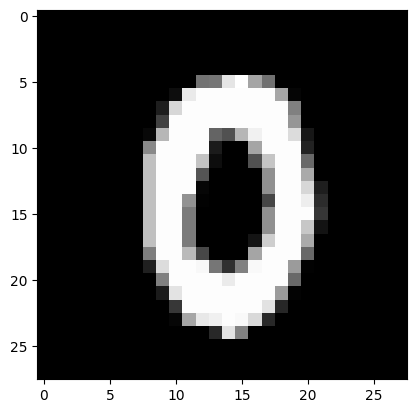

In [17]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

for img_batch, label_batch in data_loader:
    print('first batch')
    print(f"{img_batch.shape} -> [batch_size, color channel, dimension, dimension]")
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break 

#### Let's set up a device too! 
#### In my case, I am running this on a M2 chip so would only be able to utilize MPS and no GPUs. 
#### If you have any local GPUs or cloud GPUs you can use, please feel free to change this part of the code.

In [18]:
# Please feel free to change this section according to your local/cloud GPU device

device = torch.device('mps') 

device

device(type='mps')

<p style="text-align: center; font-size:30px;">Discriminator Network</p>

#### The discriminator will take an image as input, and try to classify it as either fake or real. 
#### As we are just builing a simple GAN, we will simple create a simple feedforward network with 3 linear layers.
#### If you want to see a more advanced version, take a look at my other notebook about DCGANs. 

In [19]:
image_size = 784
hidden_size = 256

import torch.nn as nn 

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2), 
    nn.Linear(hidden_size, hidden_size), 
    nn.LeakyReLU(0.2), 
    nn.Linear(hidden_size, 1), 
    nn.Sigmoid() 
)

D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

#### LeakyReLU is slightly different from the original ReLU in the sense that it allows the pass of a small gradient signal for negative values, instead of none at all. 
#### For the discriminator, it will output a single value, between 0 and 1, which can be taken as the probability of the input image being fake.

<p style="text-align: center; font-size:30px;">Generator Network</p>

#### The generator's input is generally a vector or a matrix which is used as a seed for generating an image. 

In [20]:
latent_size = 64

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size), 
    nn.ReLU(), 
    nn.Linear(hidden_size, hidden_size), 
    nn.ReLU(), 
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

#### Now since our Generator's output will be in the range of -1 and 1, we can denormalize the output and transform to view the image. 

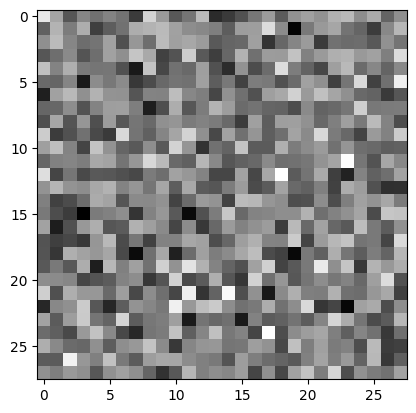

In [21]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28, 28)).detach())
plt.imshow(gen_imgs[0], cmap='gray')
plt.show()

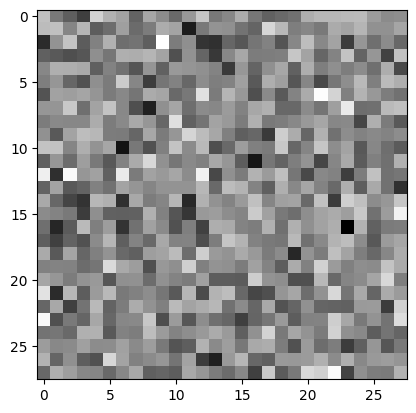

In [22]:
plt.imshow(gen_imgs[1], cmap='gray');

#### Obviously, this is going to be just random noise, which is pretty useless to us. 
#### Now, let's see how we can train these two fellows to get better at their task.

In [23]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

<p style="text-align: center; font-size:30px;">Discriminator Training</p>

#### Since the discriminator is a binary classification model, we will use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images. 

In [24]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr = 0.0002)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images) # show the probability that the image is real
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs 

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images) # show the probability that the image is real
    d_loss_fake = criterion(outputs, fake_labels) 
    fake_score = outputs 

    # Combine losses
    d_loss = d_loss_real + d_loss_fake 
    # Reset gradients
    reset_grad()
    # Compute Gradients
    d_loss.backward()
    # Adjust parameters 
    d_optimizer.step()

    return d_loss, real_score, fake_score

#### The process is pretty straightforward. 
#### We expect the discriminator (perfect) to output 1 if the image was picked from the real dataset, and 0 if it was generated. 
#### We pass in real images first, and compute the loss.
#### Then, we generate fake images using the generator, pass them into the discriminator and compute the loss. 
#### Finally, we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator. 
#### This is how we train the discriminator. 

<p style="text-align: center; font-size:30px;">Generator Training</p>

#### To me, training the discriminator is pretty straightforward and I could have guessed how it worked. 
#### However, what was tricky for me was training the generator. 
#### Apparently, we will use the discriminator as a part of the loss function. 
#### So, we generate a batch of images using the generator and pass them into the discriminator. 
#### We calculate the loss by setting the target labels to 1 (real). 
#### This is to ensure the generator's objective is to fool the discriminator; providing a fake image and saying it is a real one. 
#### We use this loss to perform gradient descent; changing the discriminator's weights, so it gets better at generating real-like images. 
#### In essence, the generator is doing its best to fool the discriminator to making it believe it is indeed giving it a real image, when it's not. 

In [25]:
g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002)

def train_generator():
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device) # To fake the discriminator that they are real images
    g_loss = criterion(D(fake_images), labels)

    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

<p style="text-align: center; font-size:30px;">Training the Model</p>

#### Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. 

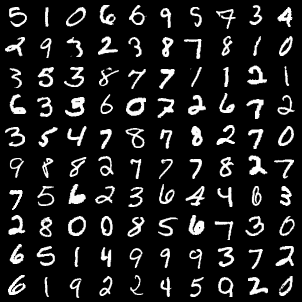

In [26]:
import os

sample_dir = '../data/samples' 
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

from IPython.display import Image
from torchvision.utils import save_image 

for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28) 
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break 

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


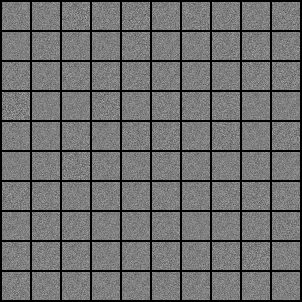

In [27]:
# Helper function to save a batch of generated images to disk at the end of every epoch

sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

#### Now let's train!

In [28]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0439, g_loss: 3.8857, D(x): 0.99, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.0476, g_loss: 5.7913, D(x): 0.99, D(G(z)): 0.04
Epoch [0/300], Step [600/600], d_loss: 0.0502, g_loss: 4.9307, D(x): 0.99, D(G(z)): 0.03
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0305, g_loss: 5.9515, D(x): 0.99, D(G(z)): 0.02
Epoch [1/300], Step [400/600], d_loss: 0.0972, g_loss: 3.1010, D(x): 0.97, D(G(z)): 0.06
Epoch [1/300], Step [600/600], d_loss: 0.1022, g_loss: 4.3774, D(x): 0.97, D(G(z)): 0.06
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.6406, g_loss: 3.0900, D(x): 0.87, D(G(z)): 0.30
Epoch [2/300], Step [400/600], d_loss: 0.3250, g_loss: 3.7307, D(x): 0.89, D(G(z)): 0.11
Epoch [2/300], Step [600/600], d_loss: 0.2061, g_loss: 4.0729, D(x): 0.95, D(G(z)): 0.10
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.0898, g_loss: 3.5426, D(x): 0.97, D(G(z)): 0.05
Epoch [3/300], Step [400/6

In [29]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

#### Let's observe how the generated images look like, after the 10th, 50th, 100th and 300th epochs of training. 
#### Hopefully, we'll be able to see the improvement of the generator.

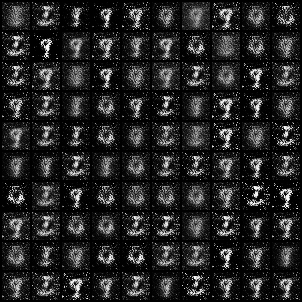

In [33]:
Image('../data/samples/fake_images-0010.png')

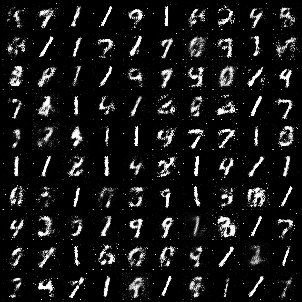

In [34]:
Image('../data/samples/fake_images-0050.png')

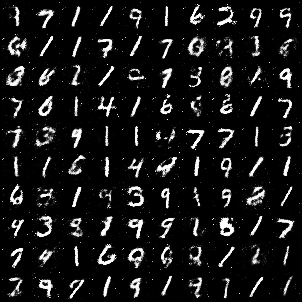

In [35]:
Image('../data/samples/fake_images-0100.png')

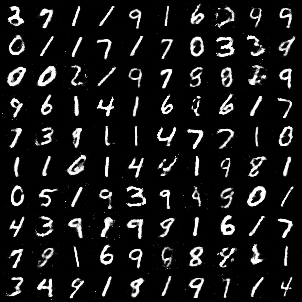

In [36]:
Image('../data/samples/fake_images-0300.png')

#### Let's take a look at the loss this time, for a more numerical analysis.

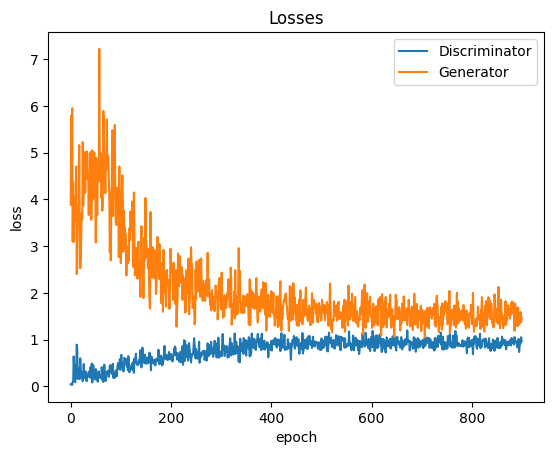

In [37]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

#### For the score output by the discriminator, we are hoping both scores converge to near 0.5 values. 
#### What this means is that for real and fake images, the discriminator can only output 0.5 probability, which literally means it is equivalent to pure guessing.

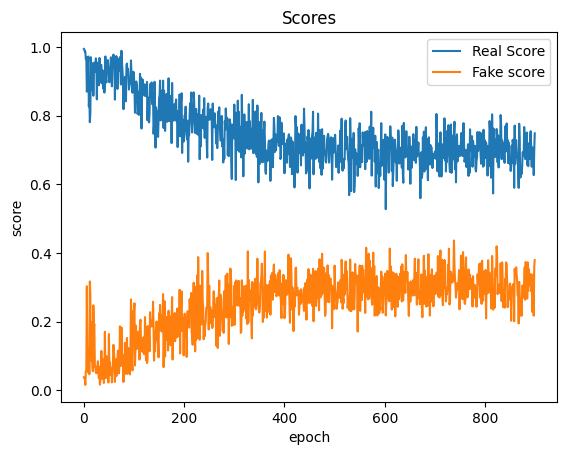

In [38]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

#### Even with such a simple model, without any convolutional layers of any sort, we were able to come up with a pretty decent model.
#### Visually, it seems to be able to generate pretty convincing pictures of the MNIST data and the losses and scores back up the observation.
#### You can try to alter the model architecture to make it more complex which can possibly come up with more realistic data!